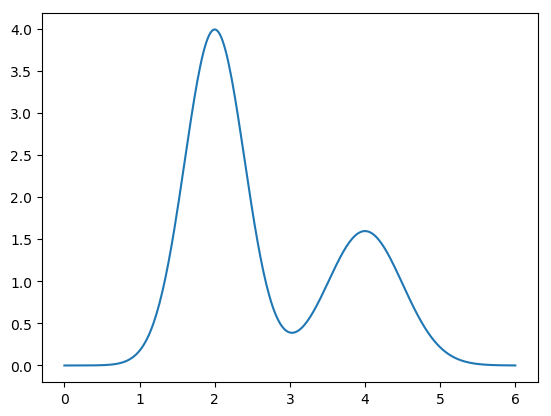

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11f5be080>

In [1]:
using PyCall
include("src/gauss_error.jl")
include("src/kernels.jl")

a = 0.
b = 6.

function phi(x::Float64)
    mu1 = 2.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.4
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

x = collect(range(a, stop=b, length=300))

using PyPlot
myplot = plot(x, phi.(x))

In [2]:
function kernel(x::Float64, y::Float64)
    return getOpticsKernels("triangular")(x, y)
end

kernel (generic function with 1 method)

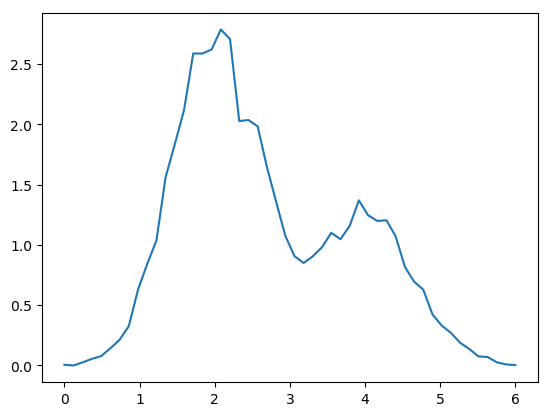

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x126188470>

In [3]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, maxevals=10^7)[1]
y = collect(range(a, stop = b, length=50))
ftrue = convolution.(y)
sig = 0.05*ftrue +[0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
plot(y, f)

In [4]:
basis = FourierBasis(a, b, 7)

FourierBasis(0.0, 6.0, 7, BaseFunction[BaseFunction(##14#18(), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 5), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 5), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 6), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 6), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 7), (0.0, 6.0)), B

In [5]:
Kmn = discretize_kernel(basis, kernel, y)

50×15 Array{Float64,2}:
 0.250095  -0.456037   -0.165376   0.341857   …  -0.00937948  -0.120485  
 0.307126  -0.545264   -0.229253   0.373424      -0.0113907   -0.130874  
 0.357436  -0.611335   -0.304273   0.365092       0.00918896  -0.133645  
 0.400236  -0.652797   -0.38574    0.319016       0.0373372   -0.113002  
 0.434696  -0.667058   -0.470112   0.236062       0.0503319   -0.0722195 
 0.462301  -0.656576   -0.555317   0.123562   …   0.0405983   -0.0295151 
 0.482653  -0.61998    -0.638108  -0.0124431      0.0133029   -0.00446055
 0.495203  -0.558138   -0.714008  -0.162716      -0.00949133  -0.0039834 
 0.499056  -0.472593   -0.778351  -0.315739      -0.0112776   -0.0130299 
 0.499132  -0.369695   -0.83272   -0.459431       0.00363327  -0.0171543 
 0.499528  -0.25965    -0.873691  -0.57344    …   0.0163977   -0.00855125
 0.500794  -0.145168   -0.901368  -0.648294       0.0166997    0.00908915
 0.500384  -0.0284848  -0.911286  -0.682019       0.0032837    0.0183176 
 ⋮            

In [6]:
model = model = GaussErrorMatrixUnfolder(omega(basis, 2))

GaussErrorMatrixUnfolder(Array{Float64,2}[[1.80387 0.0 … 0.0 0.0; 0.0 1.80387 … 0.0 0.0; … ; 0.0 0.0 … 4331.1 0.0; 0.0 0.0 … 0.0 0.0]], 15, "EmpiricalBayes", nothing)

In [7]:
result = solve(model, Kmn, f, sig)

starting solve
ending solve
starting solve_correct
starting optimal_alpha
starting optimize
ending solve_correct


Dict{String,Array{Float64,N} where N} with 3 entries:
  "alphas" => [0.5]
  "coeff"  => [1.89676, 0.867858, -0.442194, -0.536869, -0.303906, -0.373403, 0…
  "sig"    => [0.00485707 0.00156391 … -6.00247e-6 -2.4887e-5; 0.00156391 0.002…

In [8]:
phivec = PhiVec(result["coeff"], basis, result["sig"])

PhiVec([1.89676, 0.867858, -0.442194, -0.536869, -0.303906, -0.373403, 0.00994143, 0.00418602, -0.00214993, 0.000370056, -0.000663394, 7.76598e-6, -6.55064e-5, -0.000106798, -0.063544], FourierBasis(0.0, 6.0, 7, BaseFunction[BaseFunction(##14#18(), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 1), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 2), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 3), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 4), (0.0, 6.0)), BaseFunction(##15#19{Float64,Float64,Int64}(3.0, 3.0, 5), (0.0, 6.0)), BaseFunction(##16#20{Float64,Float64,Int64}(3.0, 3.0, 5), (0.0, 6.0)), BaseFunction(##15#19{Float64

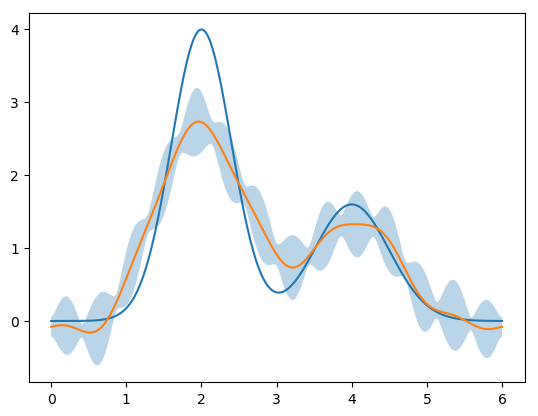

In [9]:
plot(x, phi.(x))

phi_reconstructed = call(phivec, x)
phi_reconstructed_errors = errors(phivec, x)

plot(x, call(phivec, x))
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3);